In [1]:
if("quantmod" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("quantmod")}
if("tidyquant" %in% rownames(installed.packages()) == FALSE) 
    {install.packages("tidyquant")}

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(car)
library(janitor)
library(scales)

library(tidyquant)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: lubridate


Attaching pa

In [3]:
options("getSymbols.warning4.0"=FALSE)
options("getSymbols.yahoo.warning"=FALSE)

# Project Proposal


**Yiou Long, Nikko Dumrique, Andres Zepeda, Medha Singh**

`Monday November 1st 2021`

### Introduction

***!!!DELETE***

*Begin by providing some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.*

*Clearly state the question you will try to answer with your project. Your question should involve one random variable of interest (the response) and one or more explanatory variables. Of the response variable, explain whether your project is focused on prediction, inference, or both.*

*Identify and describe the dataset that will be used to answer the question. Remember, this dataset is allowed to contain more variables than you need, in fact, exploring how the different variables in the dataset affect your model, is a crucial part of the project.*

*Also, be sure to frame your question/objectives in terms of what is already known in the literature. Be sure to include at least two scientific publications that can help frame your study (you will need to include these in the References section).*

The stock market is a stochastic process; the prices of each stock depends on multiple random variables. Some of these factors include supply-demand outlooks, companies and supply chain performance as well as volume of shares being traded. In this project, we will explore correlation between the stock price change of the suppliers of semiconductor manufacturers and the effects of that on the stock prices of the semiconductor manufacturers companies such as Intel, Apple, and AMD. Particularly, we are trying to make a prediction model from the historical stock price changes of suppliers onto the stock price changes of consumers, in the semiconductor business. In simple words, we want to see if the stock price of semiconductor manufacturing companies fluctuate along with the revenue change of their suppliers, considering a delayed effect.

For the stock prices, we will use the dataset from Yahoo Finance; and for the revenue of suppliers, we will use dataset from csimarket. 

Our response variable is the closing stock price of a semiconductor manufacturer (Intel). Explanatory variables will include Intel and competitors’ open, high, low, close and volume of the previous day’s, as well as Intel’s suppliers stock performance (in %) for 1 day, 5 day, 1 month, 3 month, and 1 year. We include such delayed information because it can take a while for supplier performance to impact manufacturers. 


### Exploratory Data Analysis (EDA)

To begin our exploratory analysis, we will visualize the stocks we believe are related to the Intel. These stocks we included are related as either a supplier, consumer, or competitor to Intel.
These stocks include: 
> AMD (_Competitor_)

> WAF.DE (_Supplier_)

> MMM (_Supplier_)

> AAPL (_Consumer_)

> DELL (_Consumer_)

The data we pull comes from Yahoo Finance via a REST API query using a library called `tidyquant`. For our proposal we decided to pull data from September 1st 2014 to March 1st 2019.

***!!!DELETE***
Demonstrate that the dataset can be read from the web into R.
Clean and wrangle your data into a tidy format.
Plot the relevant raw data, tailoring your plot in a way that addresses your question.
make sure to explore the association of the explanatory variables with the response.
your Exploratory Data Analysis (EDA) must be comprehensive with high quality plots.
Any summary tables that is relevant to your analysis.
Be sure to not print output that takes up a lot of screen space.

In [4]:
#pulling data from Yahoo finance API
intel_index <- tq_get(c('INTC','WAF.DE','AMD','AAPL','DELL', "MMM"),
               from = "2014-09-01",
               to = "2019-03-01",
               get = "stock.price")

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip



In [5]:
head(intel_index)
tail(intel_index)
nrow(intel_index)

symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INTC,2014-09-02,34.76,34.91,34.43,34.57,32094800,28.41110
INTC,2014-09-03,34.82,34.88,34.45,34.57,26668800,28.41110
INTC,2014-09-04,34.53,35.09,34.52,34.91,27632400,28.69052
INTC,2014-09-05,34.92,35.12,34.83,35.00,20841900,28.76449
INTC,2014-09-08,34.96,35.56,34.88,35.33,24859600,29.03570
INTC,2014-09-09,35.29,35.29,34.85,34.91,22333100,28.69052


symbol,date,open,high,low,close,volume,adjusted
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMM,2019-02-21,208.16,209.11,207.25,207.77,1737600,190.6579
MMM,2019-02-22,207.77,209.66,207.15,209.35,1534200,192.1078
MMM,2019-02-25,210.47,211.35,210.34,210.58,2183500,193.2365
MMM,2019-02-26,210.58,211.59,209.37,209.38,1671300,192.1353
MMM,2019-02-27,209.60,209.69,208.16,209.03,1540600,191.8142
MMM,2019-02-28,209.05,209.05,206.96,207.39,2121700,190.3092


[1] 6109

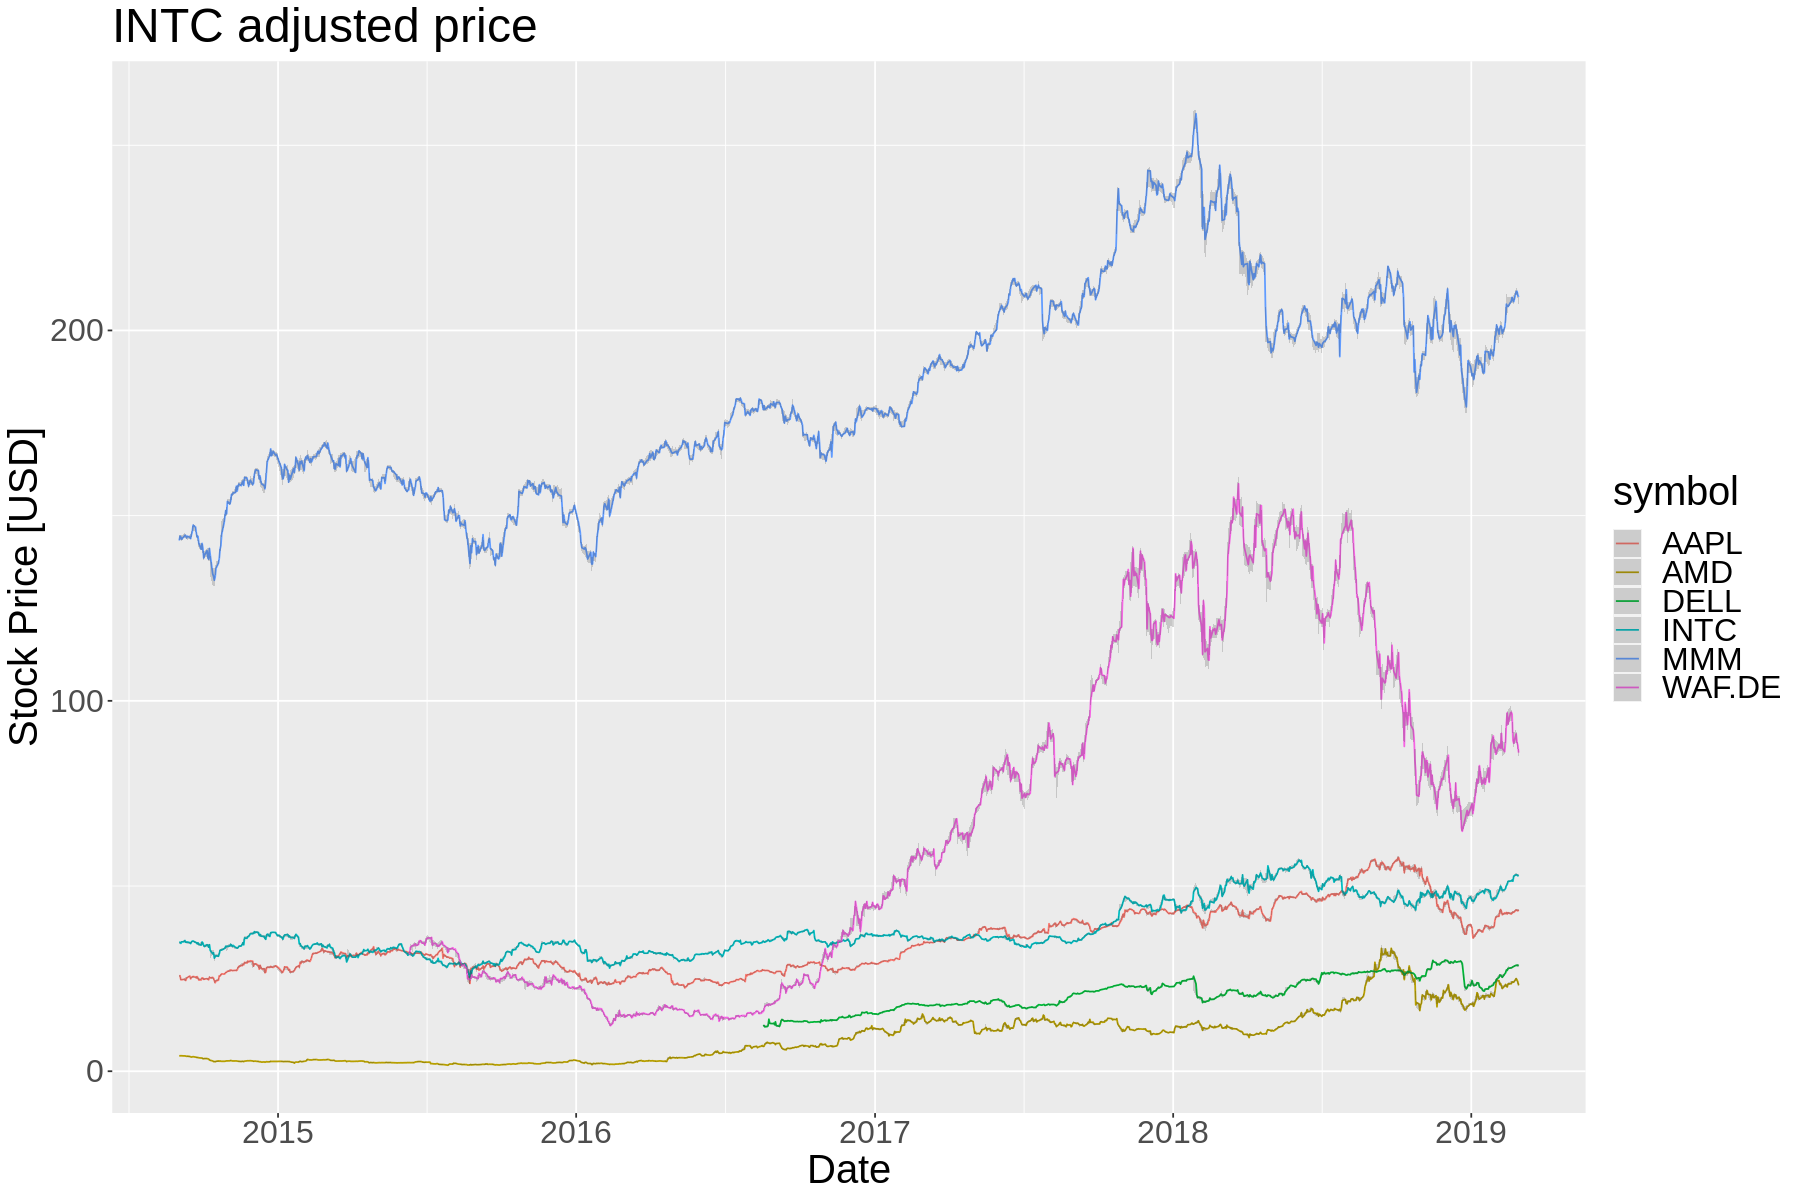

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)

#plotting the open price of each stock. 
#The grey region around the lines indicate the high and low bounds of that day
intel_plt = intel_index |> 
    group_by(symbol) |>
    mutate(symbol = factor(symbol)) |>
    ggplot() +
    geom_line(aes(x = date, 
                  y = open,
                  color = symbol)
             ) + 
    geom_ribbon(aes(x = date,
                    y = open,
                    ymin=low,
                    ymax=high,
                    color = symbol),
                alpha = 0.2, linetype=0
               ) +
    ggtitle('INTC adjusted price') + 
    xlab('Date') +
    ylab('Stock Price [USD]') +
    theme(text = element_text(size = 24))
    
intel_plt

As shown, the grey ribbon depicting the high and low of that days stock price is tightly bounding the opening price. This is expected as `open, high, low, close, and adjusted` essentially depict the same data (with some noise factor). Therefore to reduce complexity of our model, we shall utilize just the adjusted price to represent the value. We will also include volume.

In [16]:
#Selecting our wanted features from the data
intel_index = intel_index |> 
    select(symbol, date, adjusted, volume) |>
    pivot_wider(names_from = 'symbol', 
                values_from = c('volume', 'adjusted')) |> 
    mutate(month = month(date))

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `symbol` doesn't exist.


In [8]:
#standardizing data and removing NA observations
intel_index[,2:13] = intel_index[,2:13] |>
    mutate_all(~(scale(.) %>% as.vector)) 

In [9]:
#filter out observations with NA
intel_index = intel_index[complete.cases(intel_index),]
head(intel_index)
nrow(intel_index)

date,volume_INTC,volume_WAF.DE,volume_AMD,volume_AAPL,volume_DELL,volume_MMM,adjusted_INTC,adjusted_WAF.DE,adjusted_AMD,adjusted_AAPL,adjusted_DELL,adjusted_MMM,month
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-08-17,-0.7209934,-0.92066332,-0.7865773,-0.6958947,-0.6859714,-0.9124829,-0.4134618,-1.153196,-0.3671756,-0.8173021,-1.961177,-0.1439938,8
2016-08-18,-0.8985088,0.04563529,-0.3923705,-0.8670596,-0.5301094,-1.1801923,-0.4192083,-1.109062,-0.3160777,-0.8210091,-1.976696,-0.1650689,8
2016-08-19,-0.8708893,-0.46422334,0.6364369,-0.6952803,-0.2207986,-0.9651146,-0.3881759,-1.101505,-0.2337533,-0.8135942,-1.930141,-0.1519351,8
2016-08-22,-0.9935481,-0.70116378,-0.1433024,-0.6723267,-0.4802469,-0.9343468,-0.3743850,-1.119685,-0.2394308,-0.8361044,-1.920830,-0.1684272,8
2016-08-23,-0.7131496,-0.76925633,-0.4678201,-0.9039703,-0.5597373,-1.0734449,-0.3697870,-1.112785,-0.2266563,-0.8271004,-1.837031,-0.1470476,8
2016-08-24,-0.8770464,-0.68337785,-0.5742411,-0.7812360,-0.4510646,-1.1315178,-0.3985219,-1.111471,-0.2607216,-0.8488153,-1.799787,-0.1580440,8


[1] 627

In [10]:
#Correlation between response variables
index_correlation = intel_index[,2:14] |> 
    ggpairs(progress = FALSE) +
    theme (
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold")
    )

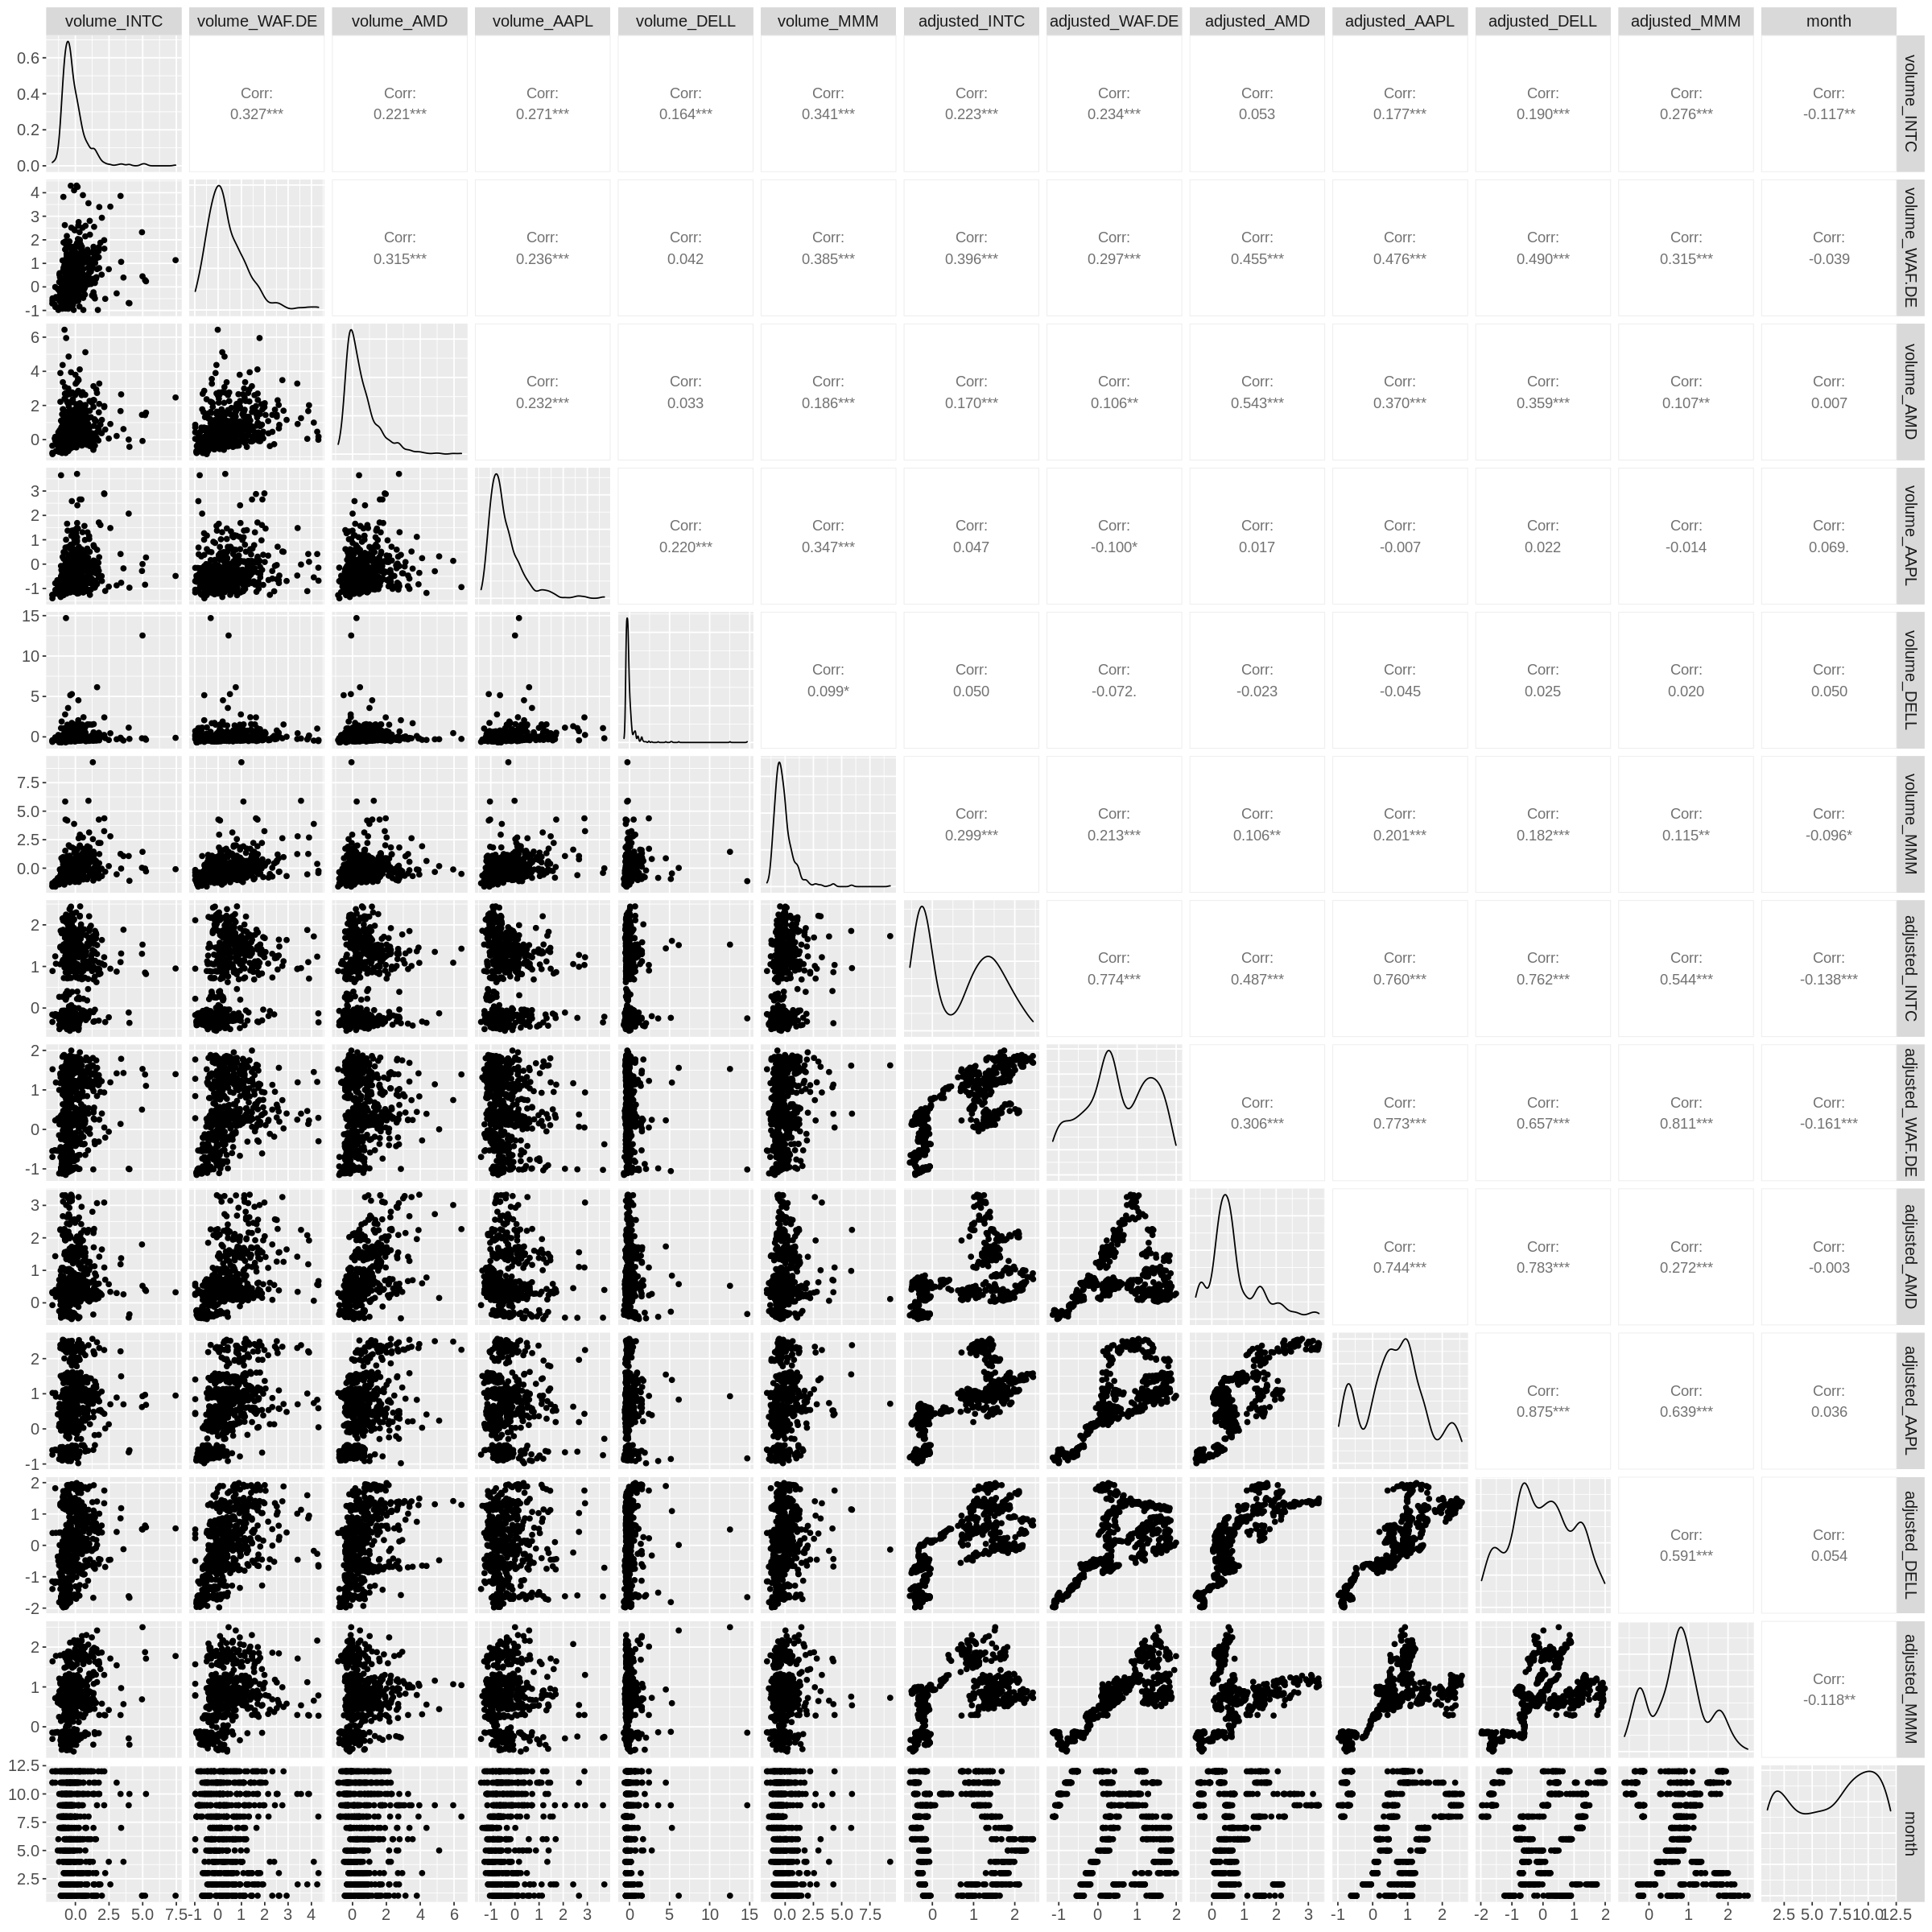

In [11]:
#plotting the matrix
options(repr.plot.width = 20, repr.plot.height = 20)
index_correlation

This plot above shows the distribution of each features and their correlation with each other. We will now display a heat-map of the correlation

In [17]:
#initialize correlation matrix
corr_matrix_intel_index = intel_index[,2:14] |> 
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_intel_index)

var1,var2,corr
<chr>,<chr>,<dbl>
volume_INTC,volume_INTC,1.0000000
volume_INTC,volume_WAF.DE,0.3267748
volume_INTC,volume_AMD,0.2208188
volume_INTC,volume_AAPL,0.2705980
volume_INTC,volume_DELL,0.1637125
volume_INTC,volume_MMM,0.3408917


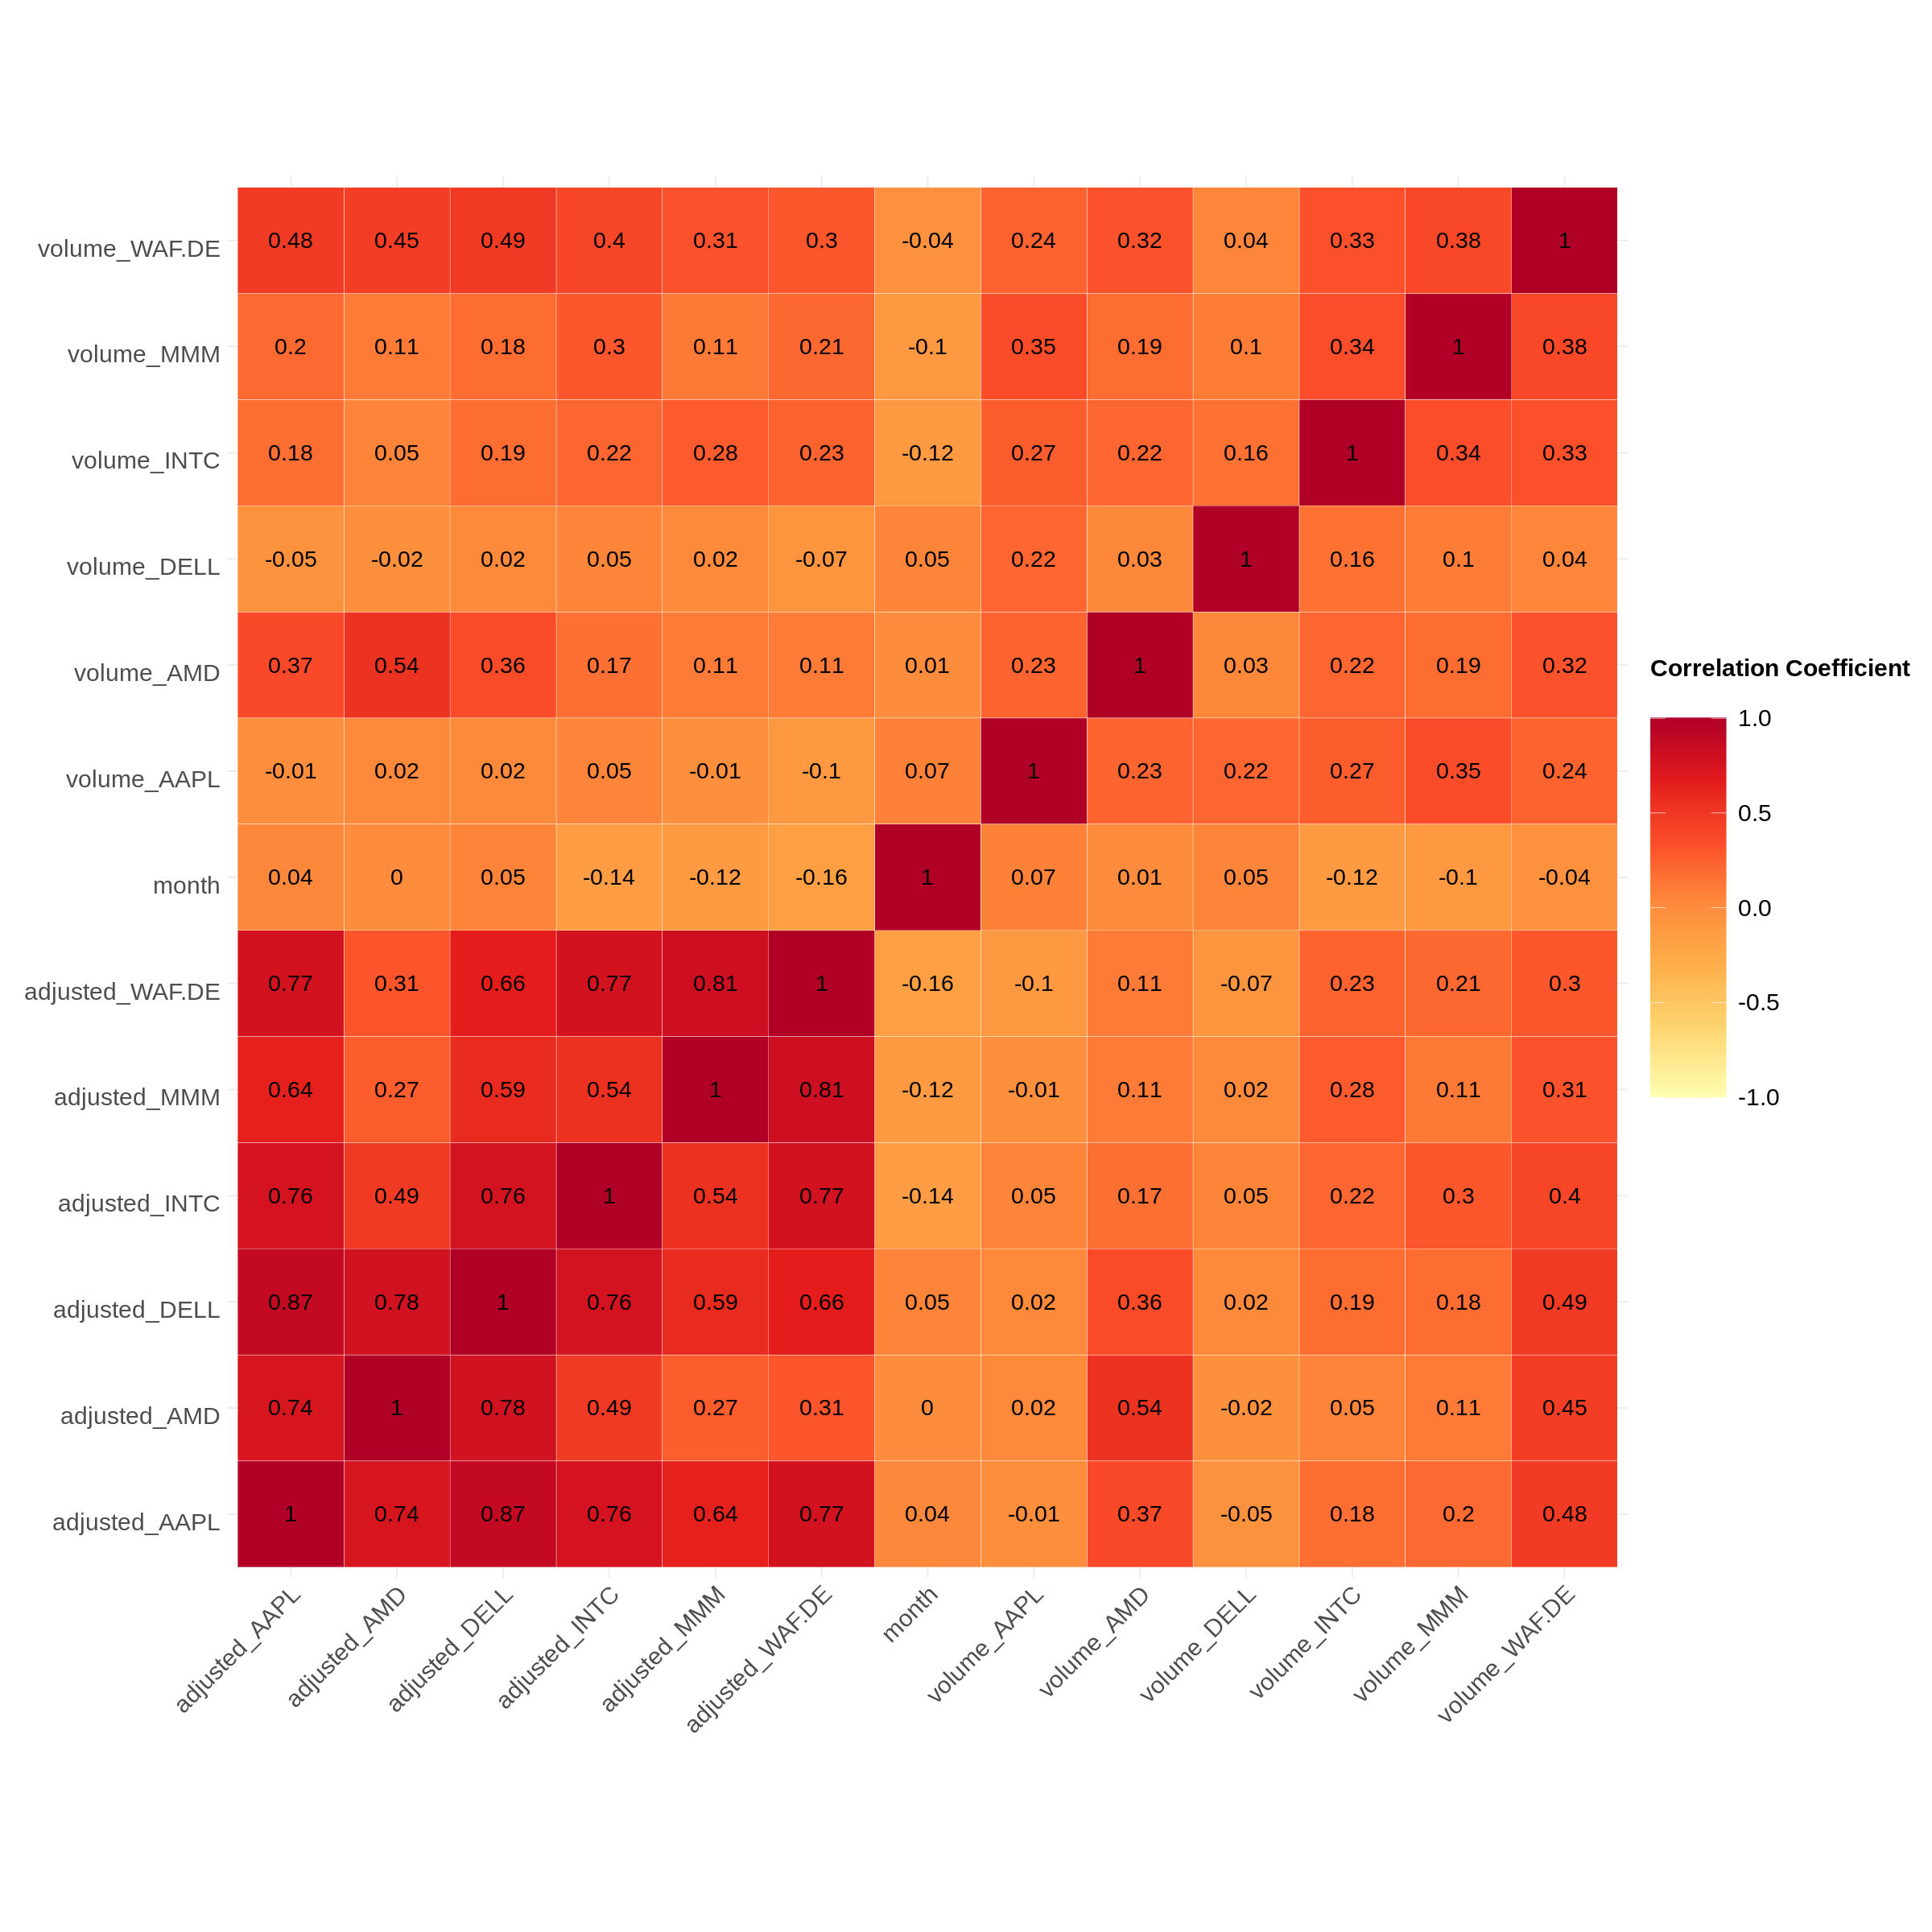

In [13]:
#correlation heatmap
plt_index_corr_matrix <- corr_matrix_intel_index %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 6)
plt_index_corr_matrix

Looking at `adjusted_INTC` on the vertical axis, the adjusted stock prices of other companies show a promising correlation. Likewise volumes of AMD, INTC, MMM, and WAF.DE are also potential indicators of the stock price for Intel.

As we see above, there are several variables with high multicollinarity. This is not surprising as this data quantify essentially the same thing over different periods of time. We should account for this with Ridge Linear model. ... With this in mind, we will gather more data that assess the performance of supply chain.

In [14]:
corr_matrix_intel_index <- intel_index %>%
  ungroup() %>%
  select(
      adjusted_INTC, volume_INTC,
      adjusted_AAPL, volume_AAPL,
      adjusted_AMD, volume_AMD,
      adjusted_DELL, volume_DELL,
      adjusted_MMM, volume_MMM,
      adjusted_WAF.DE, volume_WAF.DE,
      month
  ) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_intel_index)

var1,var2,corr
<chr>,<chr>,<dbl>
adjusted_INTC,adjusted_INTC,1.00000000
adjusted_INTC,volume_INTC,0.22270739
adjusted_INTC,adjusted_AAPL,0.76015233
adjusted_INTC,volume_AAPL,0.04650222
adjusted_INTC,adjusted_AMD,0.48733100
adjusted_INTC,volume_AMD,0.16958488


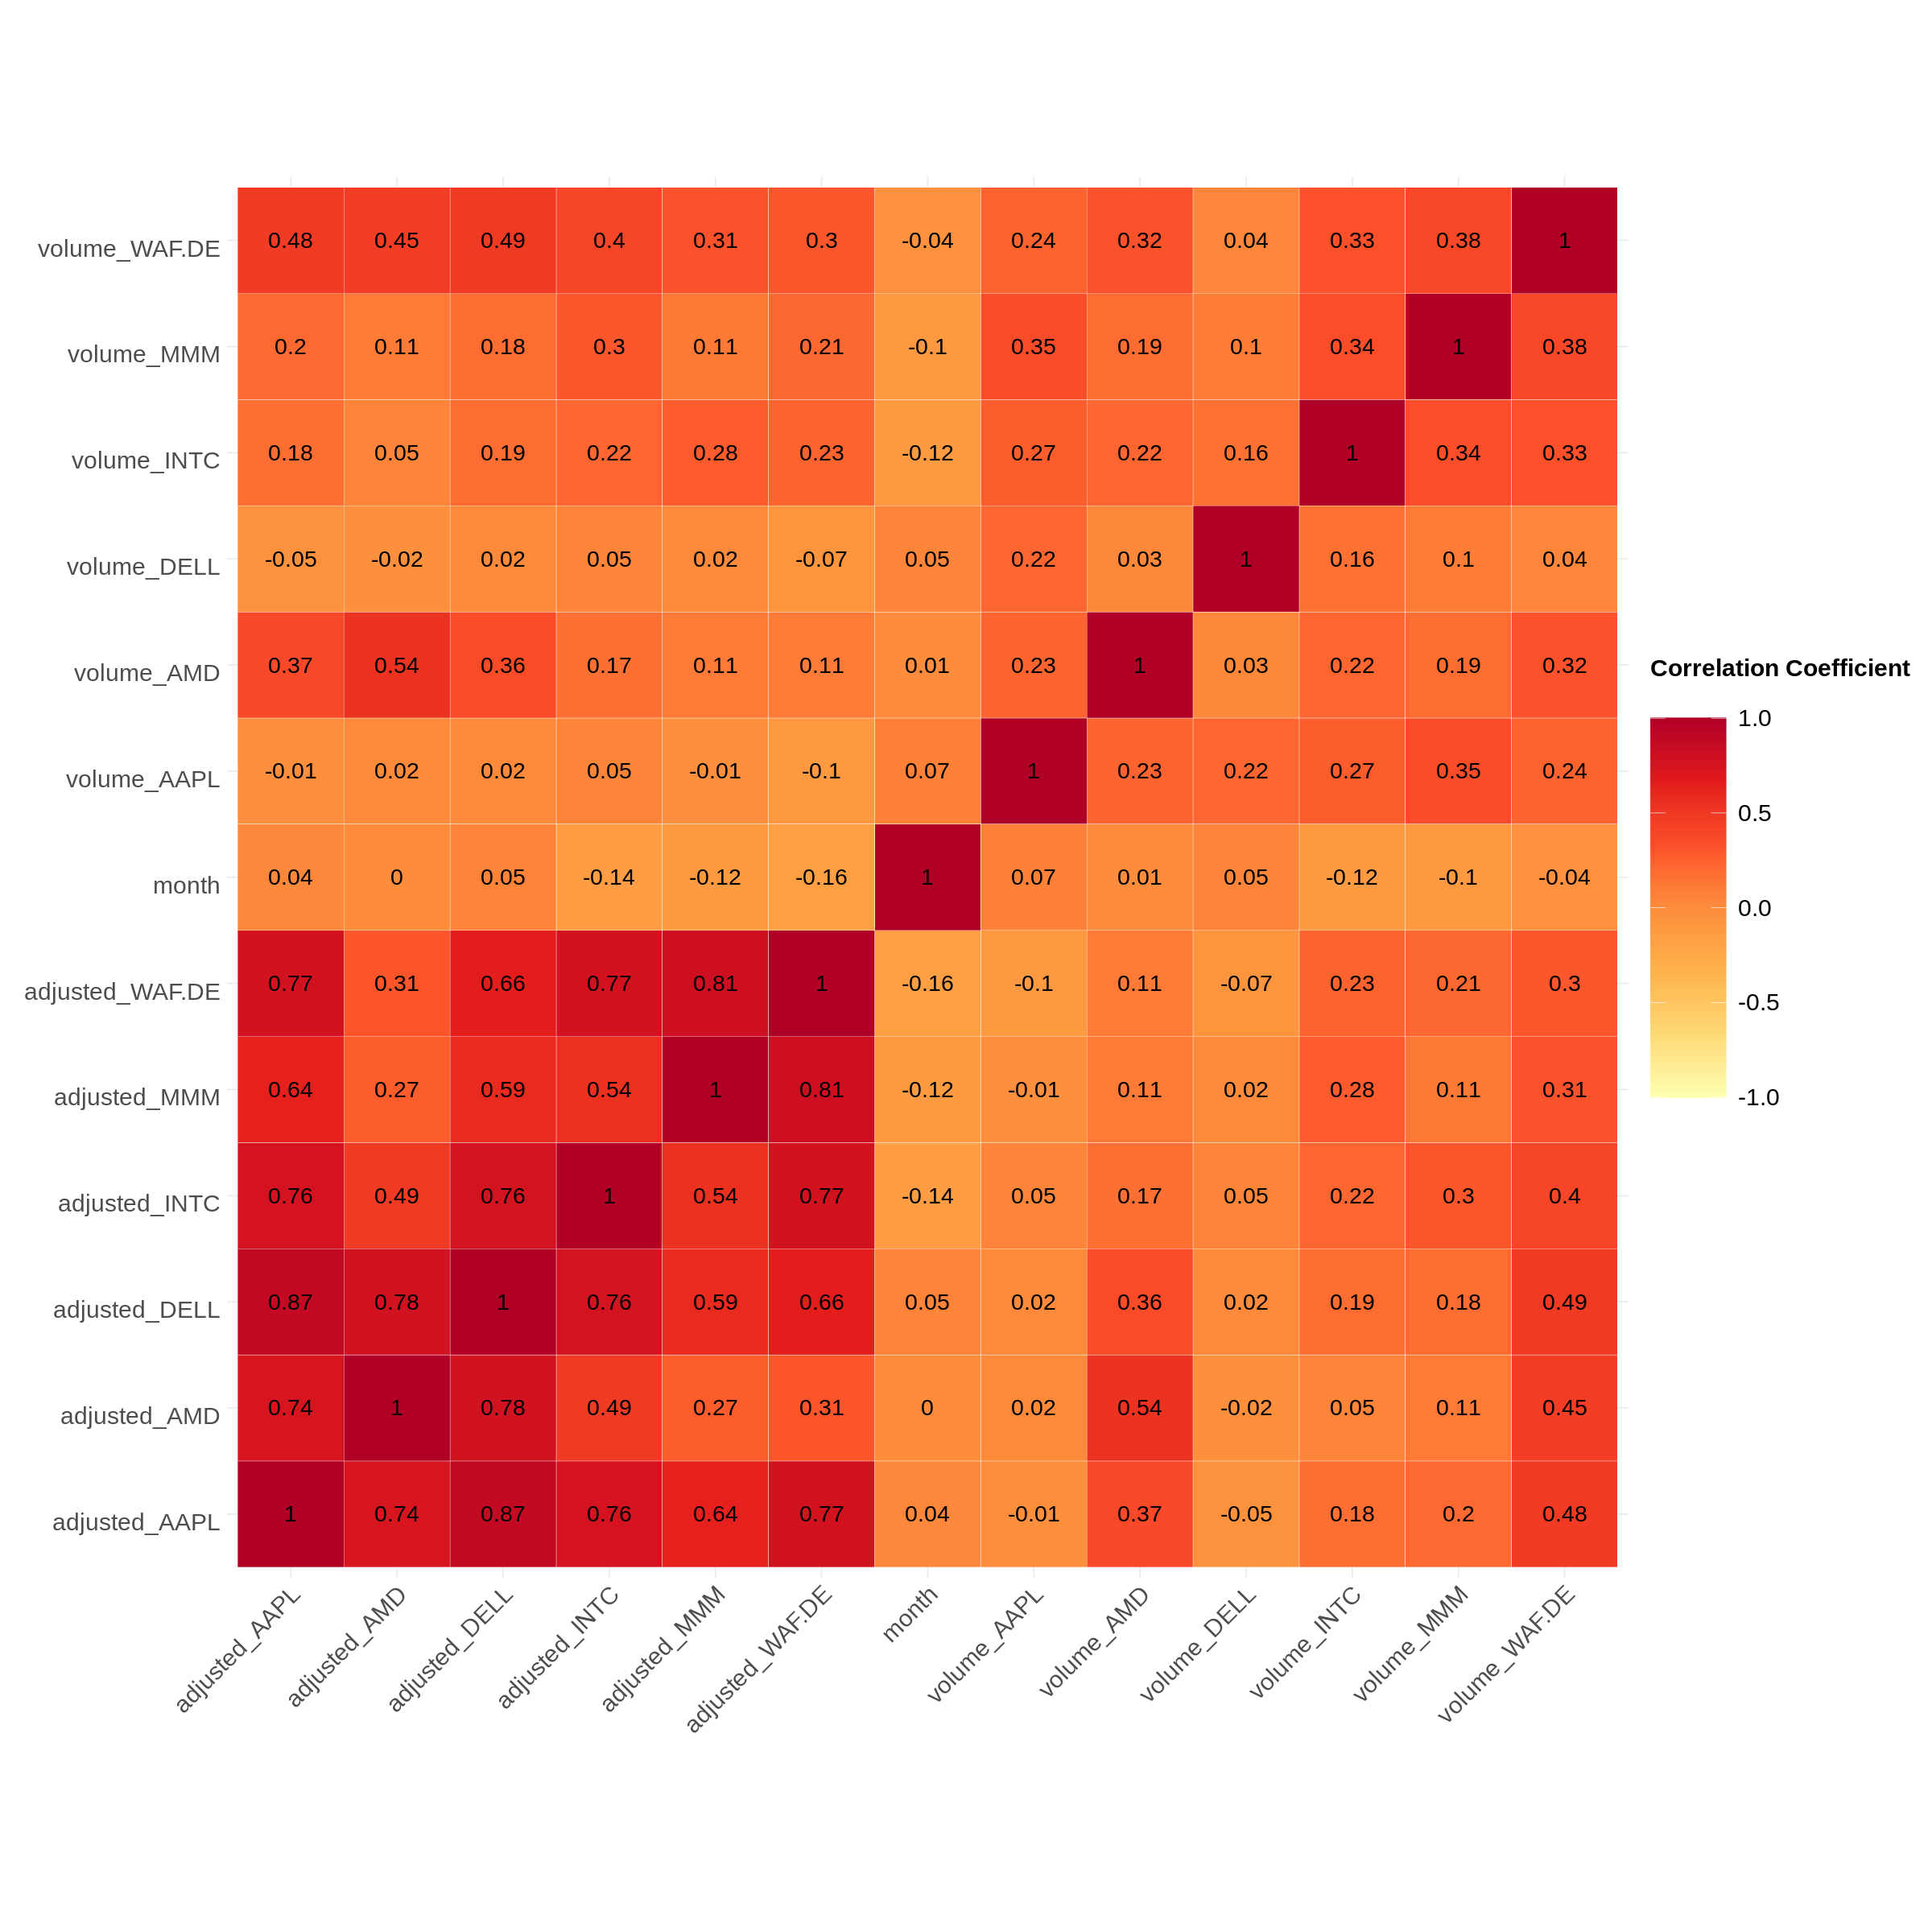

In [15]:
plt_index_corr_matrix <- corr_matrix_intel_index %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 6)
plt_index_corr_matrix

### Methods: Plan

***!!!DELETE***

The previous sections will carry over to your final report (you’ll be allowed to improve them based on feedback you get). Begin this Methods section with a brief description of “the good things” about this report – specifically, in what ways is this report trustworthy?

Finish this section by reflecting on how your final report might play out:

What methods do you plan on using?
What do you expect to achieve?
What impact could your results have?

What methods do you plan on using?
> MLR with partial interactions. Much of our data is split into their own "groups" with their own information and so there will be interactions within those groups, but not outside.

What do you expect to achieve?
> An insight towards the relation between supplier stock performance to stock performance in the tech industry, particularly computer part manufacturing. A failing supplier can have effects on how much a company can produce, but what can be their effects on the stocks of those companies.

What impact could your results have?
> Stock prediction is a famously difficult problem and this model can very useful in developing insight towards future investment strategies that produce reliable performance. A successful predictive model can help inform the volatility associated to certain stocks. 


### References

***!!!DELETE***

At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.

Project Justification:
>Segal, E. (2021, July 12). Worsening computer chip crisis shows supply chains are still at risk. Forbes. Retrieved November 6, 2021, from https://www.forbes.com/sites/edwardsegal/2021/07/12/worsening-computer-chip-crisis-shows-supply-chains-are-still-at-risk/?sh=5d5386e5e3da. 

>Supply problems take a bite out of Intel's PC chip business and its stock falls hard. SiliconANGLE. (2021, October 25). Retrieved November 6, 2021, from https://siliconangle.com/2021/10/21/supply-problems-take-bite-intels-pc-chip-business-stock-falls-hard/. 

>Tim De Chant - Oct 28, 2021 8:32 pm U. T. C. (2021, October 28). No end in sight for chip shortage as supply chain problems pile up. Ars Technica. Retrieved November 6, 2021, from https://arstechnica.com/gadgets/2021/10/no-end-in-sight-for-chip-shortage-as-supply-chain-problems-pile-up/. 

Data Sources:
>Yahoo! (n.d.). Yahoo Finance - Stock Market Live, quotes, Business & Finance News. Yahoo! Finance. Retrieved November 6, 2021, from https://finance.yahoo.com/. 

>List of INTC's suppliers and stock performance. CSIMarket. (n.d.). Retrieved November 6, 2021, from https://csimarket.com/stocks/competitionNO2.php?supply&code=INTC. 

